In [12]:
# Install yfinance if not already installed
!pip install yfinance matplotlib pandas
!pip install kagglehub

zsh:1: command not found: pip
zsh:1: command not found: pip


In [13]:
import kagglehub
import yfinance as yf
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [14]:
import os
import pandas as pd
import yfinance as yf
import time

# Download the latest version of the dataset
path = kagglehub.dataset_download("andrewmvd/sp-500-stocks")

# Print the path to the dataset directory
print("Path to dataset files:", path)

# List all files in the dataset directory
files = os.listdir(path)
print("Files in the dataset directory:", files)

# Dynamically select the first file (assuming there's only one dataset file)
dataset_file = os.path.join(path, files[1])  # Using the first file
print("Dataset file selected:", dataset_file)

# Load the dataset into a DataFrame
df = pd.read_csv(dataset_file)

# Extract the list of tickers
tickers = list(df['Symbol'][:500])  # Adjust slice as needed
print(f"Tickers extracted ({len(tickers)}): {tickers}")

# Initialize the indicators
indicators = [
    "debtToEquityRatio", "profitMargins", "returnOnEquity", "returnOnAssets", "freeCashFlow",
    "revenueGrowth", "earningsGrowth", "operatingMargins", "dividendRate", "dividendYield",
    "payoutRatio", "trailingPE", "forwardPE", "priceToSalesRatio", "marketCap",
    "enterpriseValue", "recommendationMean", "targetMeanPrice"
]

# Initialize an empty list to collect ticker data
ticker_data_list = []

# Fetch data for each ticker and populate the DataFrame
for ticker in tickers:
    try:
        print(f"Fetching data for {ticker}...")
        stock = yf.Ticker(ticker)
        info = stock.info  # Fetch company info

        # Create a dictionary for the current ticker's data
        ticker_data = {"ticker": ticker}
        for ind in indicators:
            ticker_data[ind] = info.get(ind)
        
        # Append the dictionary to the list
        ticker_data_list.append(ticker_data)
        time.sleep(0.5)  # Add a delay to avoid API rate limits
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")

# Convert the list of dictionaries into a DataFrame
data = pd.DataFrame(ticker_data_list)

# Ensure numeric columns
for col in indicators:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

# Display the resulting raw DataFrame
print("Raw Extracted Data:")
print(data.head())


Path to dataset files: /Users/maamounmraish/.cache/kagglehub/datasets/andrewmvd/sp-500-stocks/versions/1023
Files in the dataset directory: ['sp500_stocks.csv', 'sp500_companies.csv', 'sp500_index.csv']
Dataset file selected: /Users/maamounmraish/.cache/kagglehub/datasets/andrewmvd/sp-500-stocks/versions/1023/sp500_companies.csv
Tickers extracted (500): ['AAPL', 'NVDA', 'MSFT', 'AMZN', 'GOOGL', 'GOOG', 'META', 'TSLA', 'AVGO', 'BRK-B', 'WMT', 'LLY', 'JPM', 'V', 'MA', 'ORCL', 'XOM', 'UNH', 'COST', 'PG', 'HD', 'NFLX', 'JNJ', 'BAC', 'CRM', 'ABBV', 'KO', 'TMUS', 'CVX', 'MRK', 'WFC', 'CSCO', 'ACN', 'NOW', 'AXP', 'MCD', 'PEP', 'BX', 'IBM', 'DIS', 'LIN', 'TMO', 'MS', 'ABT', 'ADBE', 'AMD', 'PM', 'ISRG', 'PLTR', 'GE', 'INTU', 'GS', 'CAT', 'TXN', 'QCOM', 'VZ', 'BKNG', 'DHR', 'T', 'BLK', 'RTX', 'SPGI', 'PFE', 'HON', 'NEE', 'CMCSA', 'ANET', 'AMGN', 'PGR', 'LOW', 'SYK', 'UNP', 'TJX', 'KKR', 'SCHW', 'ETN', 'AMAT', 'BA', 'BSX', 'C', 'UBER', 'COP', 'PANW', 'ADP', 'DE', 'FI', 'BMY', 'LMT', 'GILD', 'NKE'

In [15]:
# Initialize the indicators (must match those in Cell 1)
indicators = [
    "debtToEquityRatio", "profitMargins", "returnOnEquity", "returnOnAssets", "freeCashFlow",
    "revenueGrowth", "earningsGrowth", "operatingMargins", "dividendRate", "dividendYield",
    "payoutRatio", "trailingPE", "forwardPE", "priceToSalesRatio", "marketCap",
    "enterpriseValue", "recommendationMean", "targetMeanPrice"
]

# Function to handle outliers
def handle_outliers(df, columns, method="cap"):
    """
    Handle outliers in the specified columns of a DataFrame.
    
    Parameters:
    - df: DataFrame containing the data.
    - columns: List of columns to check for outliers.
    - method: How to handle outliers: "remove" (default) or "cap".
    
    Returns:
    - DataFrame with outliers handled.
    """
    for col in columns:
        if col in df.columns:  # Ensure the column exists
            # Convert the column to numeric, replacing invalid values with NaN
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Skip columns that are all NaN
            if df[col].isna().all():
                print(f"Skipping column '{col}' as it contains all NaN values.")
                continue
            
            # Calculate IQR
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            
            if method == "remove":
                # Remove rows with outliers in this column
                df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
            elif method == "cap":
                # Cap outliers to the boundaries
                df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

# Handle outliers in the data
data_cleaned = handle_outliers(data, indicators, method="cap")

# Display cleaned data
print("Data after handling outliers:")
print(data_cleaned.head())
print(data_cleaned)

Skipping column 'debtToEquityRatio' as it contains all NaN values.
Skipping column 'freeCashFlow' as it contains all NaN values.
Skipping column 'priceToSalesRatio' as it contains all NaN values.
Data after handling outliers:
  ticker  debtToEquityRatio  profitMargins  returnOnEquity  returnOnAssets  \
0   AAPL                NaN       0.239710         0.60010        0.173035   
1   NVDA                NaN       0.386691         0.60010        0.173035   
2   MSFT                NaN       0.356080         0.35604        0.145920   
3   AMZN                NaN       0.080420         0.22558        0.070690   
4  GOOGL                NaN       0.277380         0.32101        0.164830   

   freeCashFlow  revenueGrowth  earningsGrowth  operatingMargins  \
0           NaN         0.0610         -0.3410          0.311710   
1           NaN         0.2695          0.9995          0.526692   
2           NaN         0.1600          0.1040          0.465840   
3           NaN         0.1100   

In [29]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 13.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


Removing low-variance features: ['debtToEquityRatio', 'freeCashFlow', 'priceToSalesRatio']
R^2 Score on Training Data: 0.9964622704386703
R^2 Score on Test Data: 0.35466929974179007

Feature Importance:
               Feature  Importance
6         dividendRate    0.245603
7        dividendYield    0.235531
11           marketCap    0.077947
2       returnOnAssets    0.062796
0        profitMargins    0.060153
13  recommendationMean    0.059566
10           forwardPE    0.059413
4       earningsGrowth    0.058964
12     enterpriseValue    0.045244
3        revenueGrowth    0.024134
1       returnOnEquity    0.021765
5     operatingMargins    0.016436
8          payoutRatio    0.016305
9           trailingPE    0.016142

Top 5 Stocks by Composite Score:
    ticker       score
50    INTU  517.891235
119     PH  515.887695
61    SPGI  513.862427
103   EQIX  513.291321
56    BKNG  513.129395


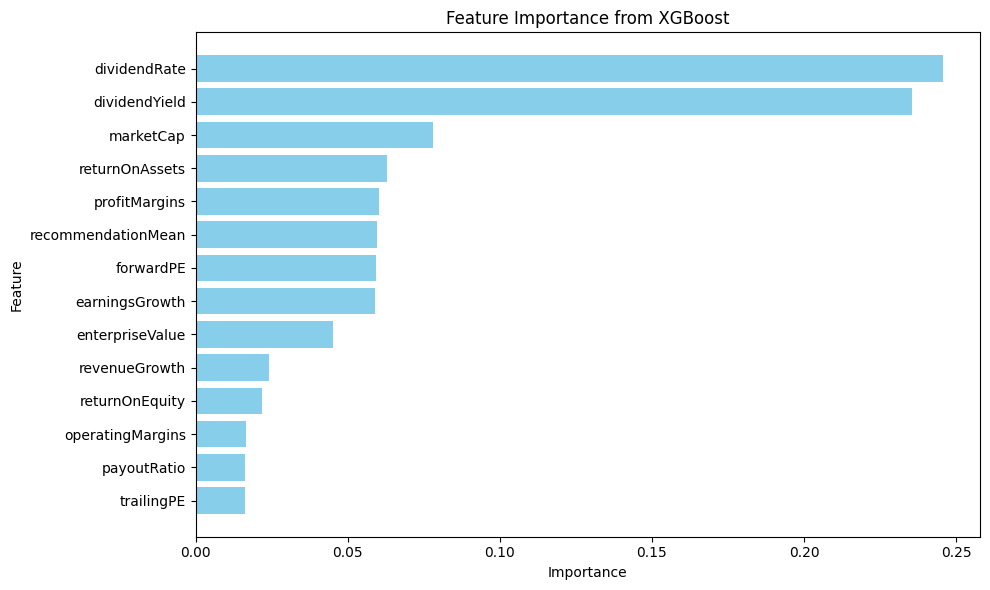

In [32]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Ensure that all columns are numeric and missing values are filled
data_cleaned = data.fillna(0)

# Ensure the indicators are present and aligned with the DataFrame
indicators = [
    "debtToEquityRatio", "profitMargins", "returnOnEquity", "returnOnAssets", "freeCashFlow",
    "revenueGrowth", "earningsGrowth", "operatingMargins", "dividendRate", "dividendYield",
    "payoutRatio", "trailingPE", "forwardPE", "priceToSalesRatio", "marketCap",
    "enterpriseValue", "recommendationMean", "targetMeanPrice"
]

# Check if all indicators exist in the DataFrame columns
missing_indicators = [ind for ind in indicators if ind not in data_cleaned.columns]
if missing_indicators:
    print(f"Missing indicators: {missing_indicators}")
    for ind in missing_indicators:
        data_cleaned[ind] = 0  # Add missing indicators as columns with zeros

# Extract target variable (e.g., targetMeanPrice) and ensure it exists
if "targetMeanPrice" in data_cleaned.columns:
    y = data_cleaned["targetMeanPrice"].fillna(0)
else:
    raise KeyError("targetMeanPrice is missing from the data.")

# Features matrix
X = data_cleaned[indicators].drop(columns=["targetMeanPrice"], errors="ignore")

# Check for low-variance features and remove them
low_variance_columns = X.columns[X.var() < 1e-6]
if len(low_variance_columns) > 0:
    print(f"Removing low-variance features: {list(low_variance_columns)}")
    X = X.drop(columns=low_variance_columns)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Evaluate the model
train_r2 = r2_score(y_train, xgb_model.predict(X_train))
test_r2 = r2_score(y_test, xgb_model.predict(X_test))
print("R^2 Score on Training Data:", train_r2)
print("R^2 Score on Test Data:", test_r2)

# Feature Importance
feature_importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

# Calculate composite scores using the model
scores = xgb_model.predict(X_scaled)

# Add scores to the original cleaned DataFrame
data_cleaned["score"] = scores

# Get the top 5 stocks by score
top_5_stocks = data_cleaned[["ticker", "score"]].sort_values(by="score", ascending=False).head(5)
print("\nTop 5 Stocks by Composite Score:")
print(top_5_stocks)

# Optional: Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Feature Importance from XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Window Size: 50, Step Size: 1, Overall R²: 0.3548
Window Size: 50, Step Size: 2, Overall R²: 0.3776
Window Size: 50, Step Size: 5, Overall R²: 0.3823
Window Size: 50, Step Size: 10, Overall R²: 0.3712
Window Size: 50, Step Size: 15, Overall R²: 0.3287
Window Size: 50, Step Size: 20, Overall R²: 0.3574
Window Size: 75, Step Size: 1, Overall R²: 0.4018
Window Size: 75, Step Size: 2, Overall R²: 0.4098
Window Size: 75, Step Size: 5, Overall R²: 0.4057
Window Size: 75, Step Size: 10, Overall R²: 0.3788
Window Size: 75, Step Size: 15, Overall R²: 0.3702
Window Size: 75, Step Size: 20, Overall R²: 0.3790
Window Size: 100, Step Size: 1, Overall R²: 0.4521
Window Size: 100, Step Size: 2, Overall R²: 0.4468
Window Size: 100, Step Size: 5, Overall R²: 0.4504
Window Size: 100, Step Size: 10, Overall R²: 0.4466
Window Size: 100, Step Size: 15, Overall R²: 0.4408
Window Size: 100, Step Size: 20, Overall R²: 0.4208
Window Size: 125, Step Size: 1, Overall R²: 0.4639
Window Size: 125, Step Size: 2, Ov

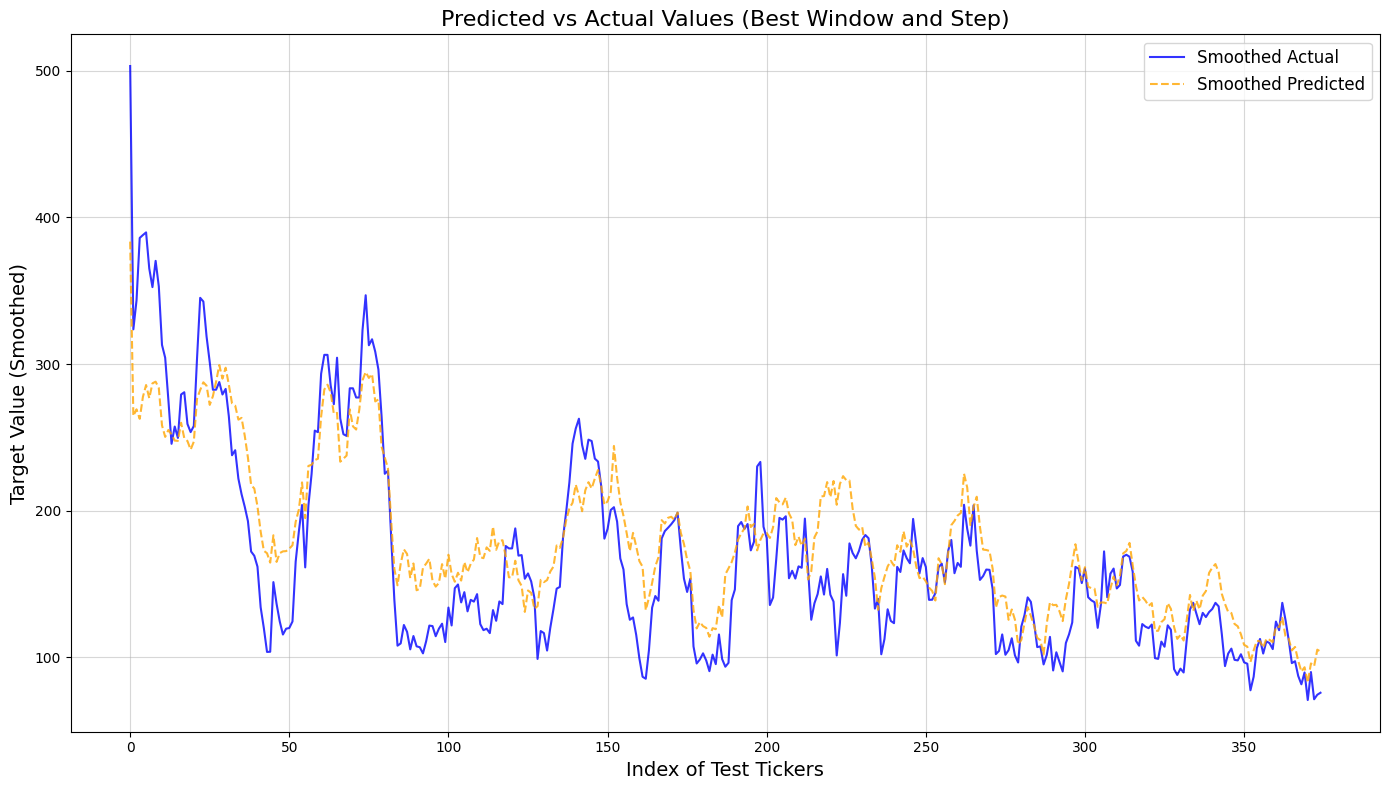

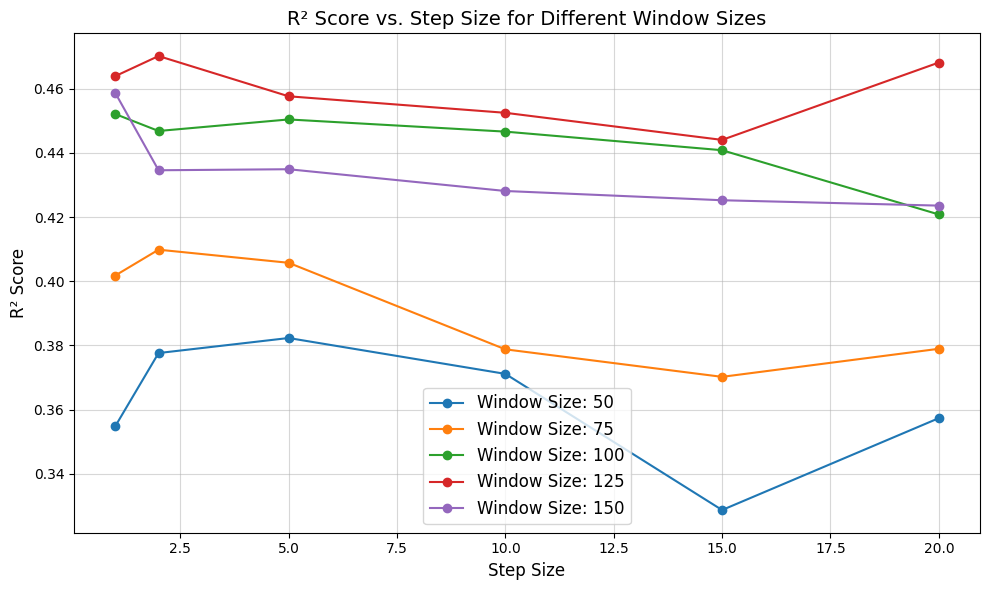

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function for grid search over rolling window parameters
def grid_search_rolling_windows(X, y, window_sizes, step_sizes):
    best_r2 = -np.inf
    best_params = None
    results_summary = []

    for window_size in window_sizes:
        for step_size in step_sizes:
            all_predictions = []
            all_actuals = []

            # Rolling window loop
            for start_idx in range(0, len(X) - window_size, step_size):
                train_idx = range(start_idx, start_idx + window_size)
                test_start = start_idx + window_size
                test_end = min(test_start + step_size, len(X))
                test_idx = range(test_start, test_end)

                if len(test_idx) == 0:
                    continue

                # Split the data
                X_train = X.iloc[train_idx]
                y_train = y.iloc[train_idx]
                X_test = X.iloc[test_idx]
                y_test = y.iloc[test_idx]

                # Train the model
                model = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
                model.fit(X_train, y_train)

                # Predict on the test set
                predictions = model.predict(X_test)

                # Store predictions and actual values
                all_predictions.extend(predictions)
                all_actuals.extend(y_test.values)

            # Calculate R² for this parameter combination
            if len(all_actuals) > 0:
                overall_r2 = r2_score(all_actuals, all_predictions)
                results_summary.append((window_size, step_size, overall_r2))
                print(f"Window Size: {window_size}, Step Size: {step_size}, Overall R²: {overall_r2:.4f}")

                if overall_r2 > best_r2:
                    best_r2 = overall_r2
                    best_params = (window_size, step_size)
                    best_predictions = all_predictions
                    best_actuals = all_actuals

    return best_params, best_r2, results_summary, best_predictions, best_actuals

# Define possible values for window_size and step_size
window_sizes = [50, 75, 100, 125, 150]
step_sizes = [1, 2, 5, 10, 15, 20]

# Run grid search
best_params, best_r2, results_summary, best_predictions, best_actuals = grid_search_rolling_windows(X, y, window_sizes, step_sizes)

# Display best parameters
print(f"\nBest Parameters: Window Size = {best_params[0]}, Step Size = {best_params[1]}")
print(f"Best Overall R²: {best_r2:.4f}")

# Create DataFrame for Actual and Predicted values
results = pd.DataFrame({
    'Actual': best_actuals,
    'Predicted': best_predictions
})

# Apply smoothing using a rolling average
results['Smoothed_Actual'] = results['Actual'].rolling(window=10, min_periods=1).mean()
results['Smoothed_Predicted'] = results['Predicted'].rolling(window=10, min_periods=1).mean()

# Plot Smoothed Actual vs Predicted
plt.figure(figsize=(14, 8))
plt.plot(results['Smoothed_Actual'], label='Smoothed Actual', color='blue', linewidth=1.5, alpha=0.8)
plt.plot(results['Smoothed_Predicted'], label='Smoothed Predicted', linestyle='--', color='orange', linewidth=1.5, alpha=0.8)

# Enhance plot appearance
plt.title('Predicted vs Actual Values (Best Window and Step)', fontsize=16)
plt.xlabel('Index of Test Tickers', fontsize=14)
plt.ylabel('Target Value (Smoothed)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

# Visualize R² results for all combinations
results_df = pd.DataFrame(results_summary, columns=["Window Size", "Step Size", "R² Score"])
plt.figure(figsize=(10, 6))
for window_size in window_sizes:
    subset = results_df[results_df["Window Size"] == window_size]
    plt.plot(subset["Step Size"], subset["R² Score"], marker='o', label=f"Window Size: {window_size}")

plt.title("R² Score vs. Step Size for Different Window Sizes", fontsize=14)
plt.xlabel("Step Size", fontsize=12)
plt.ylabel("R² Score", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()




In [34]:
import numpy as np

# Ensure 'results' DataFrame has required columns
if 'Actual' not in results.columns or 'Predicted' not in results.columns:
    raise ValueError("The 'results' DataFrame must contain 'Actual' and 'Predicted' columns.")

# Calculate directional accuracy
# Use .diff() to find the direction of change
actual_direction = np.sign(results['Actual'].diff().fillna(0))
predicted_direction = np.sign(results['Predicted'].diff().fillna(0))

# Directional accuracy: percentage of correct directional predictions
directional_accuracy = (actual_direction == predicted_direction).mean() * 100

# Display directional accuracy
print(f"Directional Accuracy: {directional_accuracy:.2f}%")

# Define grading thresholds for directional performance
def grade_directional_performance(directional_accuracy):
    """
    Grades the model based solely on directional accuracy.

    Parameters:
        directional_accuracy (float): Directional accuracy percentage

    Returns:
        str: Grade indicating model performance
    """
    if directional_accuracy >= 85:
        return "A: Excellent Directional Tracking"
    elif directional_accuracy >= 70:
        return "B: Good Directional Tracking"
    elif directional_accuracy >= 55:
        return "C: Average Directional Tracking"
    elif directional_accuracy >= 40:
        return "D: Poor Directional Tracking"
    else:
        return "F: Needs Improvement"

# Get and display the grade
grade = grade_directional_performance(directional_accuracy)
print("\nModel Grade:", grade)



Directional Accuracy: 74.67%

Model Grade: B: Good Directional Tracking
